# Goal

This notebook contains much of the code for preprocessing and model fitting for the new estimators for this project.

More specifically, this notebook has a few goals 
1. Train a propensity model for every player (probability of presence on court)
2. Train models that will predict a target given exposure (presence) and unexposure (absence)
3. Use the above models to produce metrics for every player

In [35]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import nba_on_court as noc
import shap
from sklearn.linear_model import RidgeCV, Ridge
from sklearn.metrics import root_mean_squared_error as rmse
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from scipy.spatial.distance import mahalanobis
from typing import Callable

pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 75)

# Preparing the Data

Before we can begin model training (or any statistics), we need to prepare the data.

Much of this section is preprocessing. While it makes most sense to include this in a 
separate notebook, it was easiest to do it here since I frequently refer to each of the variables.

In [36]:
data: pd.DataFrame             = pd.read_csv('../../data/nba_2223_season_stints.csv', dtype={'game_id': str})
plr_id_to_name: dict[str, str] = pd.read_csv('../../data/nba_2223_player_table.csv', index_col='player_id', dtype={'player_id': str})['player_name'].to_dict()
plr_name_to_id: dict[str, str] = dict((v,k) for k,v in plr_id_to_name.items())
box_scores: pd.DataFrame       = pd.read_csv('../../data/nba_2223_box_stats.csv')
per36_stats: pd.DataFrame      = pd.read_csv('../../data/nba_2223_per36_stats.csv')
design: pd.DataFrame           = pd.read_csv('../../design_matrices/nba_2223_season_rapm_data.csv.gz') \
                                   .drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)

First we handle the box score data. We remove accents from player names, add their IDs, and save it.

In [37]:
import unicodedata

def strip_accents(s):
   '''
   Credit to https://stackoverflow.com/a/518232
   '''
   return ''.join(c for c in unicodedata.normalize('NFD', s) 
                  if unicodedata.category(c) != 'Mn')

box_scores['Player']   = box_scores['Player'].apply(strip_accents)
box_scores['PlayerID'] = box_scores['Player'].apply(lambda name: plr_name_to_id[name])

Some players have multiple entries (different teams, different positions, etc). We pool all their data and take the total statistics.

Also merge per 36 minute statistics.

In [38]:
cols_to_keep = per36_stats.columns.difference(box_scores.columns)
box_scores = pd.merge(box_scores, per36_stats[cols_to_keep], left_index=True, right_index=True)

box_scores.drop_duplicates('Player', keep='first', inplace=True) # total is always first
box_scores.reset_index(drop=True, inplace=True)
box_scores.set_index('PlayerID', inplace=True)

The models depend on the strength of each team. We infer the strength of home and away.

Strength is defined as the sum of each player's Ball Per Minute (BPM) score.

In [39]:
# careful with the axes. the player IDs are sorted lexicographically, not numerically
home_indicators = design.replace(-1, 0).sort_index(axis=1)
away_indicators = design.replace(1, 0).mul(-1).sort_index(axis=1)
bpm             = box_scores.sort_values('PlayerID')['BPM'].astype(float).to_numpy()

data['home_strength'] = home_indicators.mul(bpm, axis=1).sum(axis=1)
data['away_strength'] = away_indicators.mul(bpm, axis=1).sum(axis=1)

Now we infer game information. We also filter out stints where the game is decided.

In [40]:
games = pd.unique(data['game_id'])

list_of_data = []
for game_id in games:
    game_data: pd.DataFrame = data[data['game_id'] == game_id]
    game_data['pm']         = game_data['home_points'] - game_data['away_points']

    game_data['home_score']         = game_data['home_points'].cumsum()
    game_data['away_score']         = game_data['away_points'].cumsum()
    game_data['end_score_margin']   = game_data['home_score'] - game_data['away_score']
    game_data['start_score_margin'] = game_data['end_score_margin'].shift(fill_value=0)

    # this is not exactly "time remaining" 
    # since some games have missing stints
    # it's a decent approximation though
    time_elapsed = game_data['minutes'].cumsum()
    game_data['start_time_left'] = 48 - time_elapsed.shift(fill_value=0)
    game_data['end_time_left']   = 48 - time_elapsed
    
    list_of_data.append(game_data)

data = pd.concat(list_of_data)    

In [41]:
# filter out stints when the game is decided
# drop iff start_time_elapsed >= 36 AND |start_score_margin| >= 20
# keep iff start_time_elapsed < 36 OR |start_score_margin| < 20
ok_stints = (data['start_time_left'] < 36) | (data['start_score_margin'].abs() < 20)
data = data[ok_stints]
design = design[ok_stints]

Finally, infer the total minutes played for each player (done at the end in order to exclude filtered stints)

In [42]:
box_scores['Min'] = np.empty(len(box_scores))
for plr_id in box_scores.index:
    box_scores.at[plr_id, 'Min'] = data['minutes'].mul(design[plr_id].abs()).sum()

# Fit the Player Models

All the preprocessing is complete. At this point, we must fit models for every player. The propensity model will be a Random Forest, while the margin models Ridge Regression.

Every player must be trained on stints where they *could* have been present, so filtering the data for each player is necessary. 
Since players can be apart of multiple teams, it is complicated to determine games they could've been a part of, as this requires determining
when the player swapped teams. **As such, the model is only trained on stints in a game where the player was on the court at least once.**

Note that we require each players' total play time to be at least 48 minutes (1 full game). Otherwise, they will not be given a metric or a model. They are not dropped from the dataset in total. (The alternative requires us to drop stints they were present in due to how "strength" and "closeness" is determined.)

In [43]:
# it's necessary to determine games where the player was present at least once
#
# moreover, it's necessary to determine whether the player was on home/away,
# in order to appropriately adjust score margin.
#
# this solution basically replaces the design matrix. instead of being an indicator
# for presence in the stint, it will serve for an indicator of presence in the game.

plr_indicators_list = []
for game_id in games:
    indicators: pd.DataFrame = design[data['game_id'] == game_id]

    sign = np.sign(indicators.sum(axis=0))

    plr_indicators_list.append(
        indicators.replace(0, {
            plr_id: indic
            for plr_id, indic in zip(indicators.columns, sign)
            if indic != 0
        })
    )

game_presence = pd.concat(plr_indicators_list)

In [44]:
game_presence.head(50)

,201939,202691,203110,203952,1626172,1629673,203210,1630164,1630228,1628978,1630541,1631157,201143,203935,1627759,1628369,1628401,203943,1629684,1627763,201933,1630573,203084,1627734,1628368,1628989,1629644,1628370,1629056,1630558,1626158,1626168,202711,1630180,1630191,1630595,1631093,1630165,1631105,1628995,202709,1628977,1627751,1629640,1630170,1630200,1631110,1630563,203926,1626196,1628380,1628966,203476,1629641,1629676,101108,1626164,1628969,1629028,1629661,1626166,1628470,1629111,203967,1627814,202687,1629006,203991,1627749,1628381,1629027,1629631,1630552,203200,1628988,1630168,201142,202681,1626220,1627732,1629651,201988,1630549,1628410,1630560,1629139,1630556,200768,202710,1628389,1628997,1629639,1629622,203473,1629216,1629130,1629312,1627783,1627832,1628384,1629018,1630567,1630173,1631132,1630625,201152,1627823,203500,1629630,1629723,1630217,1630583,1626145,1629634,1631223,1630214,1631222,201144,203482,203903,1628374,1629020,1629012,1631117,200752,1627736,1629659,1629638,1630195,1630534,1631323,1627741,1630169,1630188,1630537,1630678,1630543,1631097,204456,1629052,1630174,1629048,203497,1626156,1626157,1630162,1630183,203937,1629162,1629669,1627752,1627854,203085,200782,201935,202699,203954,1630178,1627777,1627863,1629001,1630194,1626149,1629680,2544,201566,201976,203076,1629022,1630559,1629308,1629134,1630346,1627745,1629675,203081,203924,203994,1628404,1629014,1626159,1629234,1631101,1629642,202330,203486,1626162,1626179,1629023,1630208,1629667,1628372,1630547,203925,202693,203078,204001,1628398,1628420,1630166,1629060,1626153,203115,1629655,1630264,203095,203944,1628973,1629011,1629628,1628392,1629629,1630167,1630193,201565,1630540,1630579,1627853,1629004,1631211,201569,1628981,1629645,1630224,1631095,1630231,1631106,1630578,1629726,1630528,1629614,201949,201580,203493,203915,1627827,1629029,203501,1626174,1628467,1630182,203939,1629033,1630702,1630593,1628416,1631099,1629002,203082,1628976,...,201609,203083,1627936,1627884,1628396,1631207,1630250,202331,202694,202704,1626181,1627826,201587,202322,1628379,203496,1629611,202695,1629599,1629650,1630527,1630554,1627747,1628378,1628386,1630171,1630596,1626224,201567,1629731,201577,203526,1628972,1631100,1630235,1630249,1631213,1629026,1629652,1630526,1630544,1630581,1630197,1630598,1629647,1630647,1631119,1631172,1630322,203488,1630198,1630792,1630233,1630553,1630535,1631133,1629003,1627788,1630531,1626246,1630227,1630586,1628415,1629013,1628983,201959,1631098,1630225,1630692,202685,203468,1630230,1630530,1630631,1626204,1628984,1630700,1629637,1630587,201599,1628432,202397,1628427,1631212,1631298,1628449,203920,1629660,1631320,203458,203521,1630561,203585,1628436,1631104,1630201,1630551,1631216,1629678,1630176,1630648,1630613,203552,1630177,1630550,1631217,1629117,1630202,1628382,1629603,1630205,1631103,1628962,1630695,1630288,1631199,1631114,1631160,1629646,1631230,1629656,1629636,1630591,1626167,1630557,1631113,1631246,1627742,1629627,1630529,1631108,203457,203490,1630237,1626163,1629633,1631120,1631107,1631288,1628963,202692,1631102,1630570,1630688,1626195,1630163,1630267,1628373,202722,1631165,1628991,203471,1628418,1630600,1626192,202066,1630577,1630701,1631112,1630539,1631116,203914,1629021,1630696,1631254,1631111,1629662,1629653,1628365,203992,1628993,1631121,203933,203114,203506,1630568,1630533,1626169,1629057,202689,1631169,1629674,1631115,1630184,1631109,1630639,204060,1627780,1628998,1630256,1628425,1630590,1631306,2738,1628408,1630243,201937,1630240,1630580,1631219,1628371,201980,1628464,1630620,1631123,1631245,1630637,1627739,203109,203086,1630548,203469,1630215,1630241,1630846,1631197,1630209,1631205,1630643,1629623,1629685,1641645,1629714,1629875,1631311,1630270,1628424,1630219,1627885,1630206,203487,1629677,1628221,1631466,1628435,1631303,2617,1630564,1630296,1631309,1631220,1631214,1629126,1629735,1630649,1628402,1631495,1630644,1629663,1631367
0,1,1,1,1,1,1,1,1,1,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

For both the propensity and margin models, we will need to evaluate the player team's strength.

However, this has an issue: sometimes the player is present, other times the player isn't.
- If the player is present, we can just use the other 4 players.
- If the player isn't present, we will have to remove the "closest player"

In the 2nd case, we will determine closeness based on the Mahalonabis distance of the features "POS", "2PA", "3PA", "FTA", "TRB", "AST", "STL", "BLK"

POS will be handled like so:
 - If there is exactly 1 player on court with the same position, consider them closest.
 - If there are none or more, consider Mahalonabis distance for everyone.

In [45]:
DISTANCE_FEATURES = ["2PA", "3PA", "FTA", "TRB", "AST", "STL", "BLK"]
inv_cov = np.linalg.inv(box_scores[DISTANCE_FEATURES].cov())

def determine_closest_player(ref_plr_id: str, plr_list: list[str], *, inv_cov: np.ndarray = inv_cov) -> str:
    '''
    Determine the closest player to the reference player.
    
    If there is only one player whose position is the same
    as the reference player, then this player is returned instead.

    By default, the pre-computed inverse covariance is used. 
    Pass in a different one if this needs to be changed.
    '''
    closest_plr, closest_val = None, np.inf
    same_pos_plr, count = None, 0

    ref_features  = box_scores.loc[ref_plr_id, DISTANCE_FEATURES]
    ref_positions = box_scores.at[ref_plr_id, 'Pos'].split('-')

    for plr_id in plr_list:
        for pos in ref_positions:
            if pos in box_scores.at[plr_id, 'Pos']:
                same_pos_plr = plr_id
                count += 1

        dist = mahalanobis(ref_features, box_scores.loc[plr_id, DISTANCE_FEATURES], VI=inv_cov)
        if dist < closest_val:
            closest_val = dist
            closest_plr = plr_id
    
    return same_pos_plr if count == 1 else closest_plr


In [46]:
import json

# computing the "most alike player" is expensive, so it's cached into a json file
with open('sub_cache.json') as file:
    substitution_cache: dict[str, pd.Series] = json.load(file)

def export_cache(sub_dict: dict[str, pd.Series]):
    new_cache = {
        plr: series.to_list()
        for plr, series in sub_dict.items()
    }

    with open('sub_cache.json', 'w') as fp:
        json.dump(new_cache, fp)

def get_features(df: pd.DataFrame, /) -> pd.DataFrame:
  '''
  Return the features used to train the models.

  This is purely for readability.
  '''
  return df[['start_score_margin', 'team_strength', 'opponent_strength']]

def _apply_substitution(row: pd.Series, *, ref_plr: str) -> float:
    '''
    Determines the BPM of the player that will be "substituted"

    To be applied in the 'train' functions.
    '''
    team = 'home' if row['_indicator'] == 1 else 'away'
    return box_scores.at[
       determine_closest_player(ref_plr, row[f'{team}_lineup'].split('_')), 
       'BPM'
    ]


In [47]:
def train_prop_model(
        plr_id: str, 
        *, 
        return_plr_data: bool = False,
        game_presence: pd.DataFrame = game_presence, 
        design: pd.DataFrame = design, 
        data: pd.DataFrame = data
    ) -> RandomForestClassifier | tuple[RandomForestClassifier, pd.DataFrame, pd.Series]:
    '''
    Given a player ID, train a propensity model. 
    This is trained on the features `['start_score_margin', 'team_strength', 'opponent_strength']` in that order.

    ## Parameters
    `return_plr_data`: If True, also return the data of games the player was in, and their targets.

    The remaining variables are by default their global counterparts.
    If these need to be changed, do so here.
      `game_presence`: Indicators for presence in a game
      `design`       : Indicators for presence in a stint
      `data`         : Processed game data
    '''
    # identify relevent stints
    bools: pd.Series[bool] = game_presence[plr_id].astype(bool)
    plr_data               = data[bools]
    game_presence          = game_presence.loc[bools, plr_id]

    # change the score margin to the perspective of the player
    plr_data['start_score_margin'] *= game_presence

    # identify opponent strength
    home_is_opponent = game_presence.replace(1, 0).abs().to_numpy() # home is opponent if indicator is -1. filter out 1, then swap -1 to 1.
    away_is_opponent = game_presence.replace(-1, 0).to_numpy()      # away is opponent if indicator is 1. filter out -1.
    plr_data['opponent_strength'] = plr_data['home_strength'] * home_is_opponent + plr_data['away_strength'] * away_is_opponent # only one of these is non-zero

    # identify team strength
    home_is_team = away_is_opponent
    away_is_team = home_is_opponent
    plr_data['_indicator'] = game_presence # indicates which team the player is on 

    if plr_id not in substitution_cache:
      substitution_cache[plr_id] = plr_data.apply(_apply_substitution, axis=1, ref_plr=plr_id)

    substituted_bpm = substitution_cache[plr_id]
    plr_data['team_strength'] = plr_data['home_strength'] * home_is_team + plr_data['away_strength'] * away_is_team - substituted_bpm # subtract off substituded bpm to get sum of other 4

    # extract target: 1 if on court, 0 otherwise.
    target = design.loc[bools, plr_id].abs()

    # train the model.
    model = RandomForestClassifier().fit(X=plr_data[['start_score_margin', 'team_strength', 'opponent_strength']], y=target)

    if return_plr_data:
        return model, plr_data.drop('_indicator', axis=1), target
    else:
        return model

In [48]:
def train_margin_estimator(
        plr_id: str, 
        *, 
        hypers: list[float] = [10, 50, 100, 500, 1000, 1500, 2000, 2500, 3000],
        default_hyper: float = 50,
        scoring: str | Callable = 'neg_root_mean_squared_error',
        return_plr_data: bool = False,
        game_presence: pd.DataFrame = game_presence, 
        design: pd.DataFrame = design, 
        data: pd.DataFrame = data
    ) -> tuple[RidgeCV, RidgeCV] | tuple[RidgeCV, RidgeCV, pd.DataFrame, pd.Series, tuple[pd.Series, pd.Series]]:
    '''
    Trains two models predicting margin of a stint.
    The first predicts the margin given the presence of the player.
    The second predicts the margin given the absence of the player.
    This is meant to be used in the doubly-robust estimator.

    ## Model Training
    The models will be trained using Ridge regression 
    with Leave-One-Out cross-validation. 
    The features are the same for the propensity model, namely:
    `['start_score_margin', 'team_strength', 'opponent_strength']`

    The first model will only be trained on stints where 
    the player was present, and the second will only be trained
    on stints where the player was absent (in games where they were present at least once).
    
    ## Parameters
      `hypers`          : A list of hyperparameters to be used in the cross-validation.
      `default_hyper`   : Some players are only present for a single stint, so cross-validation can't be performed. Standard ridge with this hyperparameter is used instead.
      `scoring`         : The scorer used in cross-validation. See scikit-learn documentation. RMSE by default.
      `return_plr_data` : If True, also return the data of games the player was in, and their targets. 
      A tuple of bools is also returned: the first corresponding to the unexposed data, and the second corresponding to the exposed data.
      These are meant to be used in indexing.
    
    The remaining variables are by default their global counterparts.
    If these need to be changed, do so here.
      `game_presence`: Indicators for presence in a game
      `design`       : Indicators for presence in a stint
      `data`         : Processed game data
    '''
    bools         = game_presence[plr_id].astype(bool)
    plr_data      = data[bools]
    game_presence = game_presence.loc[bools, plr_id]
    indic         = design[bools]

    # change the score margin and margin to the perspective of the player
    plr_data['start_score_margin'] *= game_presence
    plr_data['margin'] *= game_presence

    # identify opponent strength
    home_is_opponent = game_presence.replace(1, 0).abs().to_numpy() # home is opponent if indicator is -1. filter out 1, then swap -1 to 1.
    away_is_opponent = game_presence.replace(-1, 0).to_numpy()      # away is opponent if indicator is 1. filter out -1.
    plr_data['opponent_strength'] = plr_data['home_strength'] * home_is_opponent + plr_data['away_strength'] * away_is_opponent # only one of these is non-zero
    
    # identify team strength
    home_is_team = away_is_opponent
    away_is_team = home_is_opponent
    plr_data['_indicator'] = game_presence # indicates which team the player is on 

    if plr_id not in substitution_cache:
      substitution_cache[plr_id] = plr_data.apply(_apply_substitution, axis=1, ref_plr=plr_id)

    substituted_bpm = substitution_cache[plr_id]
    plr_data['team_strength'] = plr_data['home_strength'] * home_is_team + plr_data['away_strength'] * away_is_team - substituted_bpm # subtract off substituded bpm to get sum of other 4

    # "exposure" refers to presence of the player.
    # a stint is exposed if the player is present, unexposed otherwise
    exposed_bools   = indic[plr_id].astype(bool)
    unexposed_bools = ~exposed_bools

    # unexposed model
    unexposed_target    = plr_data.loc[unexposed_bools, 'margin']
    unexposed_input = plr_data.loc[unexposed_bools, ['start_score_margin', 'team_strength', 'opponent_strength']]
    if len(unexposed_input) > 1:
      unexposed_model = RidgeCV(alphas=hypers, scoring=scoring).fit(unexposed_input, unexposed_target) 
    else:
      unexposed_model = Ridge(alpha=default_hyper).fit(unexposed_input, unexposed_target)
      unexposed_model.best_score_ = rmse(unexposed_target, unexposed_model.predict(unexposed_input))

    # exposed model
    exposed_target  = plr_data.loc[exposed_bools, 'margin']
    exposed_input   = plr_data.loc[exposed_bools, ['start_score_margin', 'team_strength', 'opponent_strength']]
    if len(exposed_input) > 1:
      exposed_model = RidgeCV(alphas=hypers, scoring=scoring).fit(exposed_input, exposed_target)
    else: 
      exposed_model = Ridge(alpha=default_hyper).fit(exposed_input, exposed_target)
      exposed_model.best_score_ = rmse(exposed_target, exposed_model.predict(exposed_input))

    if return_plr_data:
        return unexposed_model, exposed_model, plr_data[['start_score_margin', 'team_strength', 'opponent_strength']], plr_data['margin'], (unexposed_bools, exposed_bools)
    else:
        return unexposed_model, exposed_model

In [49]:
prob_models: dict[str, tuple[RandomForestClassifier, pd.DataFrame, pd.Series]] = {
    plr_id: train_prop_model(plr_id, return_plr_data=True)
    for plr_id in plr_id_to_name
    if box_scores.at[plr_id, 'Min'] >= 48
}

In [50]:
pm_models = {
    plr_id: train_margin_estimator(plr_id, return_plr_data=True)
    for plr_id in plr_id_to_name
    if box_scores.at[plr_id, 'Min'] >= 48
}

# Extract Results

Now that all the propensity models are trained, we can extract information from them.

In [51]:
probs: dict[str, tuple[np.ndarray, float]] = { # probability that player is on court for their stint (not all stints are the same across players!) and accuracy of model
    plr_id: (
        model.predict_proba(get_features(plr_data))[:, 1], 
        model.score(get_features(plr_data), plr_target)
    )
    for plr_id, (model, plr_data, plr_target) in prob_models.items()
}

In [52]:
predicted_marg: dict[str, tuple[tuple[np.ndarray, float], tuple[np.ndarray, float]]] = { # predicted margins and RMSE of the models
    plr_id: (
        (unexposed_model.predict(model_data), -1 * exposed_model.best_score_),
        (exposed_model.predict(model_data), -1 * unexposed_model.best_score_)
    )
    for plr_id, (unexposed_model, exposed_model, model_data, _, _) in pm_models.items()
}

In [53]:
def summarize(arr, label=''):
    '''
    Print summary statistics of given array.
    Label is printed first.
    '''
    print(
        label,
        f'Average: {np.mean(arr)}',
        f'Median: {np.median(arr)}',
        f'St. Dev.: {np.std(arr)}',
        f'Min: {np.min(arr)}',
        f'Max: {np.max(arr)}',
        sep='\n'
    )

accuracies  = [item[1] for item in probs.values()]
rmses_exp   = [item[0][1] for item in predicted_marg.values()]
rmses_unexp = [item[1][1] for item in predicted_marg.values()]

summarize(accuracies, '\nAccuracy')
summarize(rmses_exp, '\nRMSE: Exposed')
summarize(rmses_unexp, '\nRMSE: Unexposed')


Accuracy
Average: 0.9954454950968211
Median: 0.9958034620154242
St. Dev.: 0.003265921252272132
Min: 0.9813084112149533
Max: 1.0

RMSE: Exposed
Average: 69.19779516839
Median: 70.05853524806037
St. Dev.: 5.049041752595755
Min: 46.018898069539034
Max: 89.61313296614082

RMSE: Unexposed
Average: 69.89241531761813
Median: 69.83126294442789
St. Dev.: 3.587212237319214
Min: 53.51546252934445
Max: 84.82067212016696


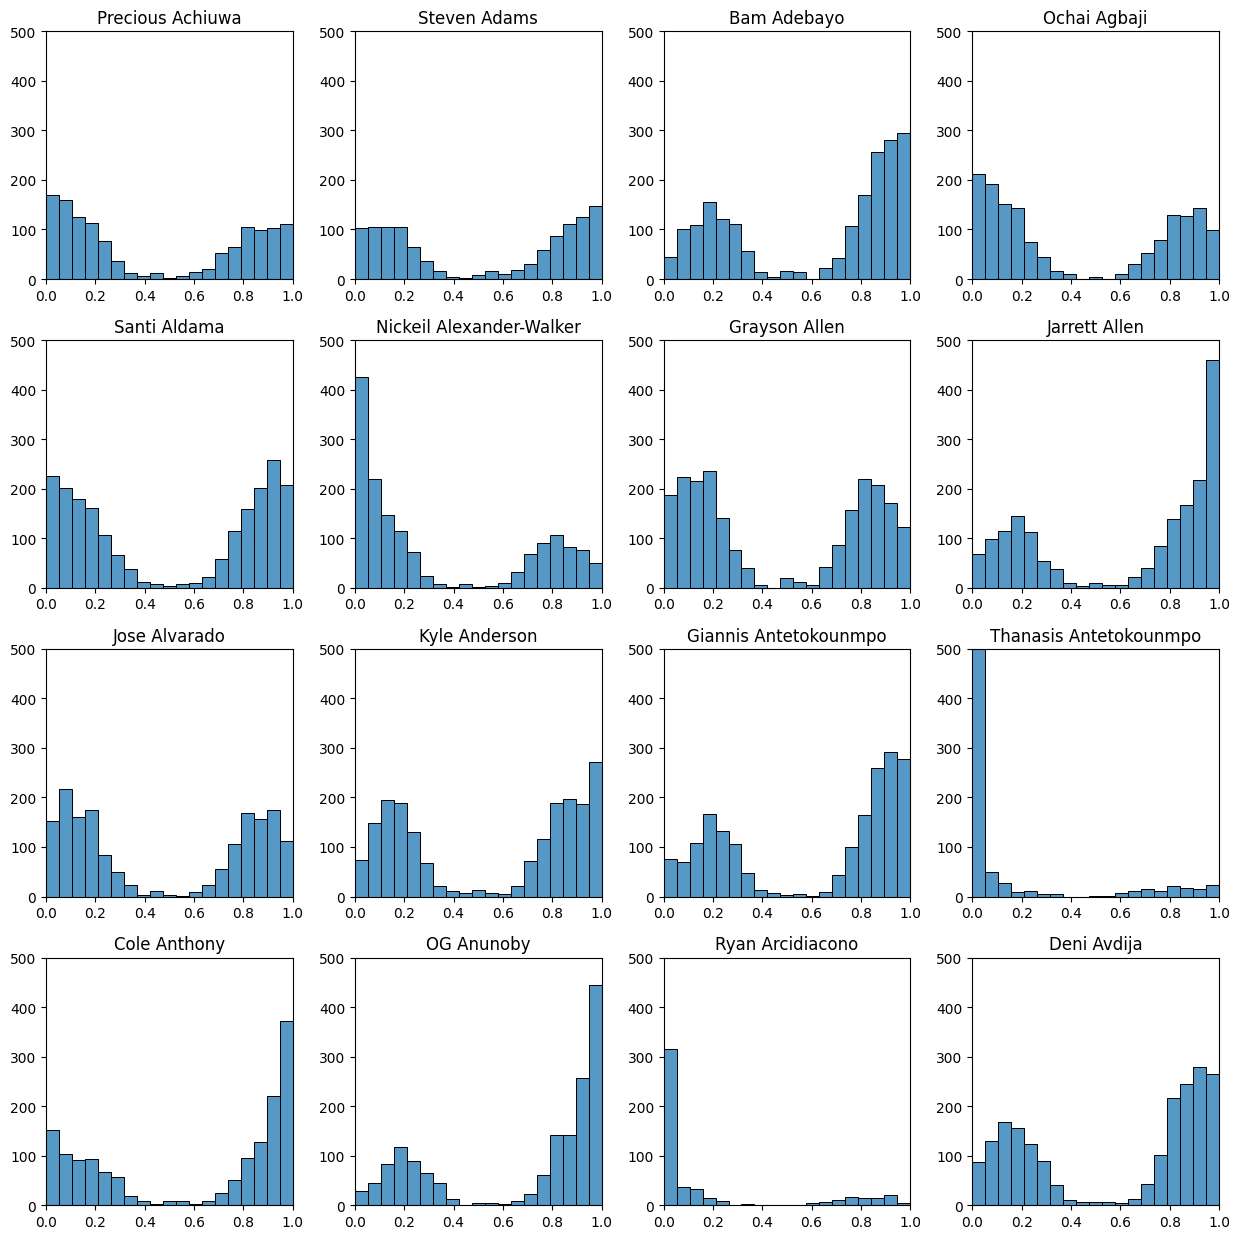

In [54]:
# make a collage
n = 4

fig, ax = plt.subplots(n,n, figsize=(12.5, 12.5))

plr_ids   = list(probs)
plr_probs = list(probs.values())

for k in range(n**2):
    i = k // n
    j = k % n

    plr_id, plr_prob = plr_ids[k], plr_probs[k][0]

    graph = sns.histplot(plr_prob, bins=np.linspace(0, 1, 20), ax=ax[i, j])
    graph.set_xlim(0, 1)
    graph.set_ylim(0, 500)
    graph.set_ylabel('')
    graph.set_title(plr_id_to_name[plr_id])

fig.tight_layout()
fig.show()

# Compute Weighted Estimators

Now that we have propensity scores, we will use them for a few estimators of skill. Here, $\mu$ represents player skill.

Note that margin is defined as $\frac{\text{PM}}{\text{No. of Possesstions}} * 100$

Define
- $p_i$ = Propensity score of stint $i$ (i.e. probability of presence)
- $t_i$ = 0 if absent, 1 if present
- $y_i$ = The margin of the stint (in the eyes of the player)
- $N$   = Total number of stints

## Inverse-Propensity Weighting

Then
$$
\mu_{\text{ipw}} = N^{-1} \left( \sum_{i=1}^{N} \dfrac{t_i y_i}{p_{i}} - \sum_{i=1}^{N} \dfrac{(1 - t_i) y_i}{1 - p_i} \right)
$$

While this looks complicated, this is simply the expected difference of weighted sums, where the weights for each observation is $\frac{1}{p_i}$ if the player was present, and $\frac{1}{1 - p_i}$ if the player wasn't present. In other words, each stint is weighted by the inverse of the probability of being correct.

Note that the above formula is not implemented. The following one is used instead
$$
    \mu_{\text{ipw}} = \dfrac{\sum y_i t_i p_{i}^{-1}}{\sum t_i p_{i}^{-1}} - \dfrac{\sum y_i (1 - t_i) (1 - p_i)^{-1}}{\sum (1 - t_i) (1 - p_i)^{-1}}
$$

This is essentially a normalized version of IPW. Aside from being more numerically stable, it has lower variance.

## Overlapping Weights

Using the same definitions as above, the overlapping estimator is defined as
$$
\mu_{\text{overlap}} = N^{-1} \left( \sum_{i=1}^{N} t_i (1 - p_i) y_i - \sum_{i=1}^{N} (1 - t_i) p_i y_i \right)
$$

Essentially, where IPW assigned weights based on the probability of being correct, overlapping weights assign weights based on the probability of being incorrect. This mainly upweights stints that can be in either treatment group (i.e. it upweights stints that could either have a player's presence, or could lack a player's presence).

# Compute DR Estimators

sing both the propensity and margin models, we can compute the doubly-robust estimators for each player. 

Let $i$ be a stint. Define
- $y_i$ - True margin of stint $i$.
- $\hat{y}_{i}^{(0)}$ - Predicted margin, given absence of player.
- $\hat{y}_{i}^{(1)}$ - Predicted margin, given presence of player.
- $p_i$ - Propensity score of stint (i.e. probability of player presence)
- $t_i$ - Indicator of player presence. 0 = Absent, 1 = Present.

Note that the margins are in the eyes of the player.

## IPW-DR Estimator

 Then the doubly robust estimators are defined as
$$
    \begin{align*}
        \text{IPW-DR}_1 &= N^{-1} \sum_{i=1}^{N} \hat{y}_{i}^{(1)} + \frac{t_i (y_i - \hat{y}_{i}^{(1)})}{p_i} \\
        \text{IPW-DR}_0 &= N^{-1} \sum_{i=1}^{N} \hat{y}_{i}^{(0)} + \frac{(1 - t_i) (y_i - \hat{y}_{i}^{(0)})}{1 - p_i} \\
    \end{align*}
$$
Where $\text{DR}_0$ is the expected margin under absence, and $\text{DR}_1$ is the expected margin under presence. Thus, we can compute the player's skill by finding $\mu_{\text{IPW-DR}} = \text{DR}_1 - \text{DR}_0$

## Overlap-DR Estimator

Using the same definition as above, we have
$$
    \begin{align*}
        \text{O-DR}_1 &= N^{-1} \sum_{i=1}^{N} \hat{y}_{i}^{(1)} + t_i (y_i - \hat{y}_{i}^{(1)}) (1 - p_i) \\
        \text{O-DR}_0 &= N^{-1} \sum_{i=1}^{N} \hat{y}_{i}^{(0)} + (1 - t_i) (y_i - \hat{y}_{i}^{(0)}) p_i \\
    \end{align*}
$$

Then $\mu_{\text{O-DR}} = \text{O-DR}_1 - \text{O-DR}_0$

# Division by Zero

To prevent divisions by 0 in the estimators, $p_i$ is constrainted to be between $[\epsilon, 1-\epsilon]$ for some $\epsilon > 0$. This is carried over for the overlapping estimator for consistency. We use $\epsilon = 0.001$

In [98]:
eps = 1e-3 # probability threshold
ipw_estimators = {}
overlap_estimators = {}
ipw_dr_estimators = {}
odr_estimators = {}

def normalize(arr: np.ndarray, /) -> np.ndarray:
    return arr / arr.sum()

for plr_id, model_stuff in prob_models.items():
    plr_data       = model_stuff[1]
    presence_probs = probs[plr_id][0] # the order of these probabilities matches the order of the player's game data
    margin         = plr_data['margin'] * game_presence.loc[plr_data.index, plr_id] # get margin in the eyes of the player
    true_presence  = design.loc[plr_data.index, plr_id].abs()
    N              = len(presence_probs)
    
    # filter out extreme values
    presence_probs[presence_probs < eps] = eps
    presence_probs[presence_probs > 1 - eps] = 1 - eps

    ipw_on_weights = normalize(true_presence / presence_probs)
    ipw_off_weights = normalize((1 - true_presence) / (1 - presence_probs))
    ipw_estimators[plr_id] = np.dot(margin, ipw_on_weights - ipw_off_weights)

    #overlap_on_weights  = normalize(true_presence * (1 - presence_probs))
    #overlap_off_weights = normalize((1 - true_presence) * presence_probs)
    #overlap_estimators[plr_id] = np.dot(margin, overlap_on_weights - overlap_off_weights)
    overlap_estimators[plr_id] = np.dot(margin, true_presence * (1 - presence_probs) - (1 - true_presence) * presence_probs) / N
    
    # predicted_marg == plr_id: (exposed_outcome, rmse), (unexposed_outcome, rmse)
    exposed_marg    = predicted_marg[plr_id][0][0]
    unexposed_marg  = predicted_marg[plr_id][1][0]
    
    #ipw_dr1 = np.sum(exposed_marg + true_presence * (margin - exposed_marg) / presence_probs) / (1 / presence_probs).sum()
    #ipw_dr0 = np.sum(unexposed_marg + (1 - true_presence) * (margin - unexposed_marg) / (1 - presence_probs)) / (1 / (1 - presence_probs)).sum()
    ipw_dr1 = np.sum(exposed_marg + true_presence * (margin - exposed_marg) / presence_probs) / N
    ipw_dr0 = np.sum(unexposed_marg + (1 - true_presence) * (margin - unexposed_marg) / (1 - presence_probs)) / N
    ipw_dr_estimators[plr_id] = ipw_dr1 - ipw_dr0

    # odr1 = np.sum(exposed_marg + true_presence * (margin - exposed_marg) * (1 - presence_probs)) / (1 - presence_probs).sum()
    # odr0 = np.sum(unexposed_marg + (1 - true_presence) * (margin - unexposed_marg) * presence_probs) / presence_probs.sum()
    odr1 = np.sum(exposed_marg + true_presence * (margin - exposed_marg) * (1 - presence_probs)) / N
    odr0 = np.sum(unexposed_marg + (1 - true_presence) * (margin - unexposed_marg) * presence_probs) / N
    odr_estimators[plr_id] = odr1 - odr0


In [99]:
# add the data to existing results
results = pd.read_csv('../../results/ryurko_results.csv', index_col='Player ID', dtype={'Player ID': str})
results['IPW Effect'] = np.empty(len(results))
results['Overlap Effect'] = np.empty(len(results))
results['IPW-DR Effect'] = np.empty(len(results))
results['Overlap-DR Effect'] = np.empty(len(results))
results['Minutes'] = np.empty(len(results))

for plr_id, plr_ipw in ipw_estimators.items():
    results.at[plr_id, 'IPW Effect'] = plr_ipw
    results.at[plr_id, 'Overlap Effect'] = overlap_estimators[plr_id]
    results.at[plr_id, 'IPW-DR Effect'] = ipw_dr_estimators[plr_id]
    results.at[plr_id, 'Overlap-DR Effect'] = odr_estimators[plr_id]
    results.at[plr_id, 'Minutes'] = box_scores.at[plr_id, 'Min']

results.to_csv('../../results/ryurko_results.csv')

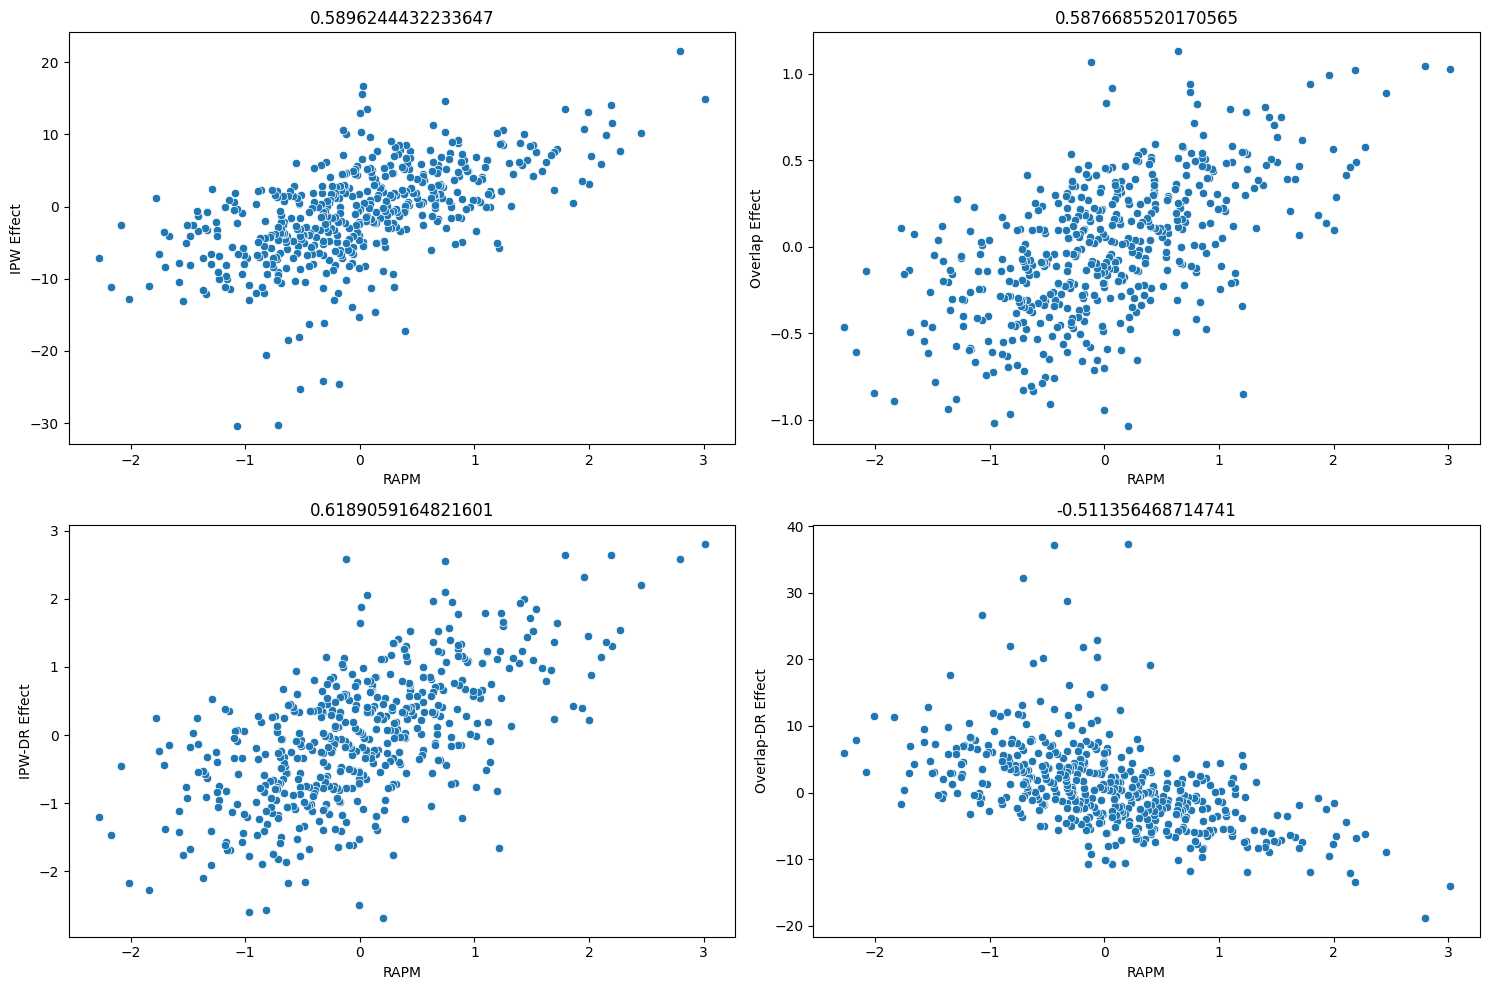

In [100]:
bools = results['Minutes'] >= 48

fig, ax = plt.subplots(2, 2, figsize=(15, 10))

sns.scatterplot(results[bools], x='RAPM', y='IPW Effect', ax=ax[0, 0]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'IPW Effect']))
sns.scatterplot(results[bools], x='RAPM', y='Overlap Effect', ax=ax[0, 1]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'Overlap Effect']))
sns.scatterplot(results[bools], x='RAPM', y='IPW-DR Effect', ax=ax[1, 0]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'IPW-DR Effect']))
sns.scatterplot(results[bools], x='RAPM', y='Overlap-DR Effect', ax=ax[1, 1]).set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'Overlap-DR Effect']))


fig.tight_layout()
fig.show()

Text(0.5, 1.0, '0.6093895419859008')

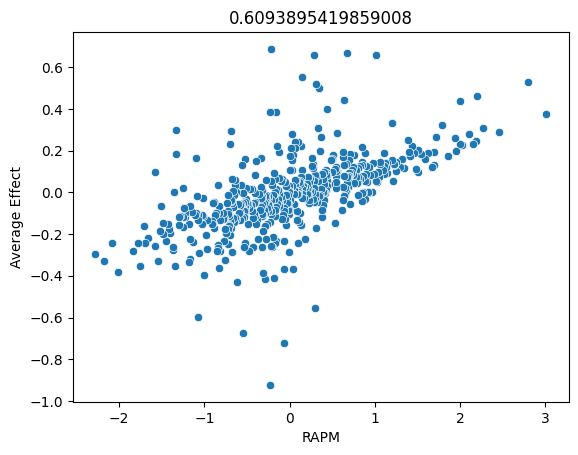

In [101]:
sns.scatterplot(results[bools], x='RAPM', y='Average Effect').set_title(results.loc[bools, 'RAPM'].corr(results.loc[bools, 'Average Effect']))

In [102]:
print(results['Average Effect'].corr(results['RAPM']))


0.45585430983992736


# Analyze Importance of Features

Here, we investigate the importance of the input features into both the PM model and propensity models.

We will compute each feature's SHAP values.

In [103]:
# random forest
'''
n = 4

fig, ax = plt.subplots(n,n, figsize=(20, 15))
plr_ids = list(probs)

for k in range(n**2):
    i = k // n
    j = k % n

    plr_id              = plr_ids[k]
    plr_model, plr_data = prob_models[plr_id][0], get_features(prob_models[plr_id][1])
    
    subset      = shap.utils.sample(plr_data, int(np.ceil(0.1 * len(plr_data))), random_state=1234) # use 10% of data as a mask
    explainer   = shap.Explainer(plr_model.predict, subset)
    shap_values = explainer(plr_data)

    graph = shap.plots.bar(shap_values, ax=ax[i, j], show=False)
    graph.set_title(plr_id_to_name[plr_id])

fig.tight_layout()
fig.show()
'''

'\nn = 4\n\nfig, ax = plt.subplots(n,n, figsize=(20, 15))\nplr_ids = list(probs)\n\nfor k in range(n**2):\n    i = k // n\n    j = k % n\n\n    plr_id              = plr_ids[k]\n    plr_model, plr_data = prob_models[plr_id][0], get_features(prob_models[plr_id][1])\n    \n    subset      = shap.utils.sample(plr_data, int(np.ceil(0.1 * len(plr_data))), random_state=1234) # use 10% of data as a mask\n    explainer   = shap.Explainer(plr_model.predict, subset)\n    shap_values = explainer(plr_data)\n\n    graph = shap.plots.bar(shap_values, ax=ax[i, j], show=False)\n    graph.set_title(plr_id_to_name[plr_id])\n\nfig.tight_layout()\nfig.show()\n'

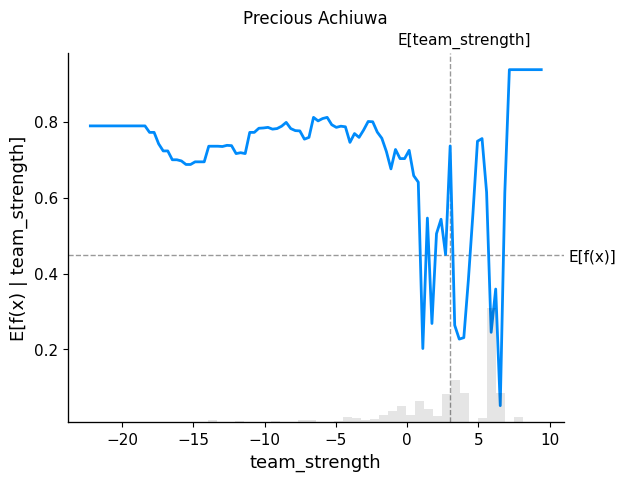

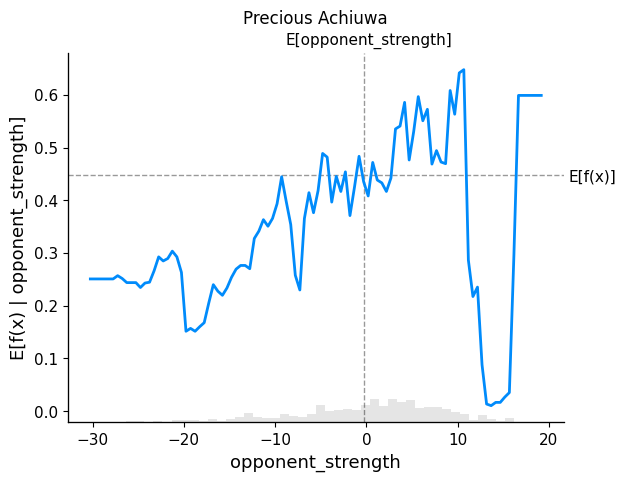

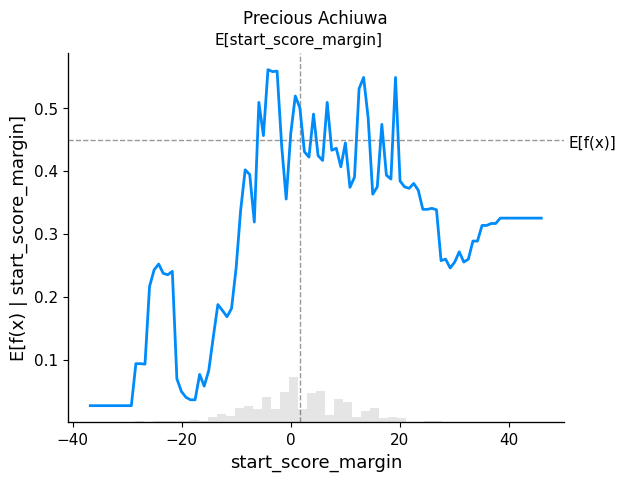

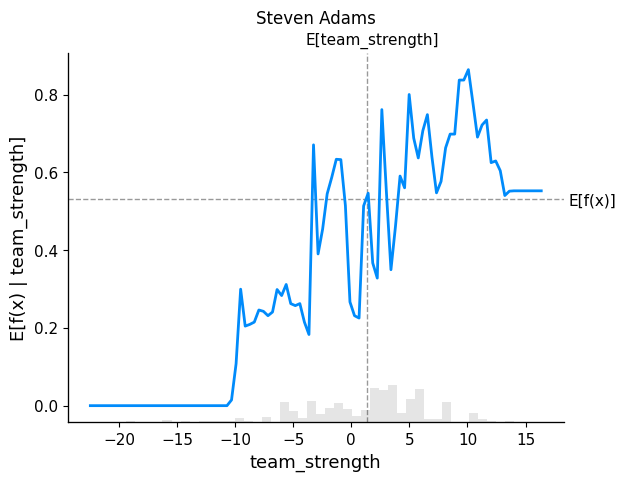

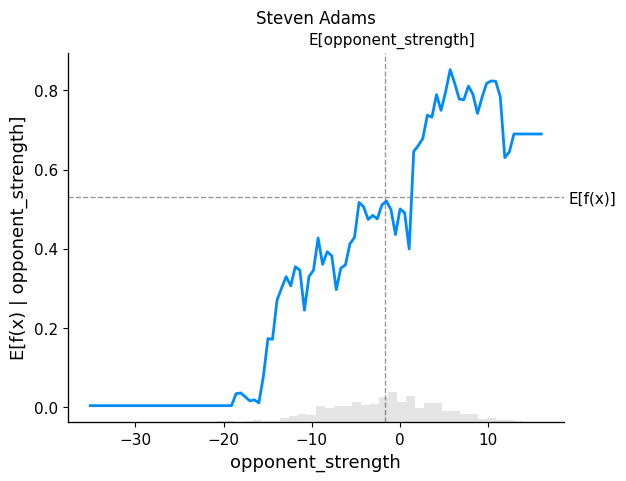

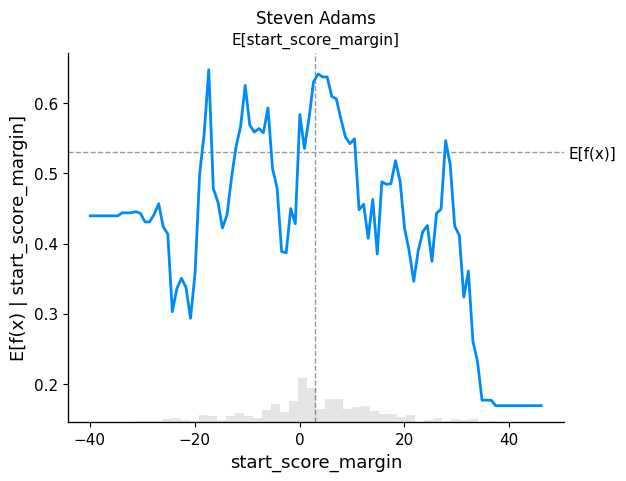

In [104]:
# random forest
plr_ids = list(probs)

for k in range(2):

    plr_id              = plr_ids[k]
    plr_model, plr_data = prob_models[plr_id][0], get_features(prob_models[plr_id][1])
    
    time_fig, time_ax = shap.partial_dependence_plot(
        "team_strength",
        plr_model.predict,
        plr_data,
        model_expected_value=True, 
        feature_expected_value=True,
        show=False,
        ice=False
    )
    time_ax.set_title(plr_id_to_name[plr_id])
    time_fig.show()
    
    opp_fig, opp_ax = shap.plots.partial_dependence(
        "opponent_strength",
        plr_model.predict,
        plr_data,
        model_expected_value=True, 
        feature_expected_value=True,
        show=False,
        ice=False
    )
    opp_ax.set_title(plr_id_to_name[plr_id])
    opp_fig.show()
    
    margin_fig, margin_ax = shap.plots.partial_dependence(
        "start_score_margin",
        plr_model.predict,
        plr_data,
        model_expected_value=True, 
        feature_expected_value=True,
        show=False,
        ice=False
    )
    margin_ax.set_title(plr_id_to_name[plr_id])
    margin_fig.show()

# Out-of-Sample Testing

We now compute the RMSE of our models, and compare it against the RAPM RMSE.

All data is from the 2023-2024 season.



In [105]:
oos_data: pd.DataFrame      = pd.read_csv('../../design_matrices/nba_2324_season_rapm_data.csv.gz', dtype={'game_id': str})
oos_players: dict[str, str] = pd.read_csv('../../data/nba_2324_player_table.csv', index_col='player_id', dtype={'player_id': str})['player_name'].to_dict()
oos_design                  = oos_data.drop(['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin'], axis=1)
oos_data                    = oos_data[['game_id', 'stint_id', 'n_pos', 'home_points', 'away_points', 'minutes', 'margin']]

First, we evaluate over players who participated in both the 23 and 24 season. This will be the **Total OOS RMSE**.

In [106]:
combined_plrs = np.intersect1d(list(oos_players), list(plr_id_to_name))
missing_from_2324 = list(set(plr_id_to_name) - set(combined_plrs))
missing_from_2223 = list(set(oos_players) - set(combined_plrs))

# filter out stints with new players
has_missing_player: pd.Series = oos_design[missing_from_2223].abs().sum(axis=1).astype(bool)

total_oos_design = oos_design.loc[~has_missing_player].drop(missing_from_2223, axis=1)
total_oos_target = oos_data.loc[~has_missing_player, 'margin']


# add in players missing from 23/24 (they're just all zeros)
total_oos_design[missing_from_2324] = pd.DataFrame(
    data=np.zeros((len(total_oos_design.index), len(missing_from_2324)), dtype=np.int64),
    index=total_oos_design.index
)

# reorder the columns so the ordering matches the ordering of the 22/23 data
total_oos_design = total_oos_design[design.columns]

total_oos_design

,201939,202691,203110,203952,1626172,1629673,203210,1630164,1630228,1628978,1630541,1631157,201143,203935,1627759,1628369,1628401,203943,1629684,1627763,201933,1630573,203084,1627734,1628368,1628989,1629644,1628370,1629056,1630558,1626158,1626168,202711,1630180,1630191,1630595,1631093,1630165,1631105,1628995,202709,1628977,1627751,1629640,1630170,1630200,1631110,1630563,203926,1626196,1628380,1628966,203476,1629641,1629676,101108,1626164,1628969,1629028,1629661,1626166,1628470,1629111,203967,1627814,202687,1629006,203991,1627749,1628381,1629027,1629631,1630552,203200,1628988,1630168,201142,202681,1626220,1627732,1629651,201988,1630549,1628410,1630560,1629139,1630556,200768,202710,1628389,1628997,1629639,1629622,203473,1629216,1629130,1629312,1627783,1627832,1628384,1629018,1630567,1630173,1631132,1630625,201152,1627823,203500,1629630,1629723,1630217,1630583,1626145,1629634,1631223,1630214,1631222,201144,203482,203903,1628374,1629020,1629012,1631117,200752,1627736,1629659,1629638,1630195,1630534,1631323,1627741,1630169,1630188,1630537,1630678,1630543,1631097,204456,1629052,1630174,1629048,203497,1626156,1626157,1630162,1630183,203937,1629162,1629669,1627752,1627854,203085,200782,201935,202699,203954,1630178,1627777,1627863,1629001,1630194,1626149,1629680,2544,201566,201976,203076,1629022,1630559,1629308,1629134,1630346,1627745,1629675,203081,203924,203994,1628404,1629014,1626159,1629234,1631101,1629642,202330,203486,1626162,1626179,1629023,1630208,1629667,1628372,1630547,203925,202693,203078,204001,1628398,1628420,1630166,1629060,1626153,203115,1629655,1630264,203095,203944,1628973,1629011,1629628,1628392,1629629,1630167,1630193,201565,1630540,1630579,1627853,1629004,1631211,201569,1628981,1629645,1630224,1631095,1630231,1631106,1630578,1629726,1630528,1629614,201949,201580,203493,203915,1627827,1629029,203501,1626174,1628467,1630182,203939,1629033,1630702,1630593,1628416,1631099,1629002,203082,1628976,...,201609,203083,1627936,1627884,1628396,1631207,1630250,202331,202694,202704,1626181,1627826,201587,202322,1628379,203496,1629611,202695,1629599,1629650,1630527,1630554,1627747,1628378,1628386,1630171,1630596,1626224,201567,1629731,201577,203526,1628972,1631100,1630235,1630249,1631213,1629026,1629652,1630526,1630544,1630581,1630197,1630598,1629647,1630647,1631119,1631172,1630322,203488,1630198,1630792,1630233,1630553,1630535,1631133,1629003,1627788,1630531,1626246,1630227,1630586,1628415,1629013,1628983,201959,1631098,1630225,1630692,202685,203468,1630230,1630530,1630631,1626204,1628984,1630700,1629637,1630587,201599,1628432,202397,1628427,1631212,1631298,1628449,203920,1629660,1631320,203458,203521,1630561,203585,1628436,1631104,1630201,1630551,1631216,1629678,1630176,1630648,1630613,203552,1630177,1630550,1631217,1629117,1630202,1628382,1629603,1630205,1631103,1628962,1630695,1630288,1631199,1631114,1631160,1629646,1631230,1629656,1629636,1630591,1626167,1630557,1631113,1631246,1627742,1629627,1630529,1631108,203457,203490,1630237,1626163,1629633,1631120,1631107,1631288,1628963,202692,1631102,1630570,1630688,1626195,1630163,1630267,1628373,202722,1631165,1628991,203471,1628418,1630600,1626192,202066,1630577,1630701,1631112,1630539,1631116,203914,1629021,1630696,1631254,1631111,1629662,1629653,1628365,203992,1628993,1631121,203933,203114,203506,1630568,1630533,1626169,1629057,202689,1631169,1629674,1631115,1630184,1631109,1630639,204060,1627780,1628998,1630256,1628425,1630590,1631306,2738,1628408,1630243,201937,1630240,1630580,1631219,1628371,201980,1628464,1630620,1631123,1631245,1630637,1627739,203109,203086,1630548,203469,1630215,1630241,1630846,1631197,1630209,1631205,1630643,1629623,1629685,1641645,1629714,1629875,1631311,1630270,1628424,1630219,1627885,1630206,203487,1629677,1628221,1631466,1628435,1631303,2617,1630564,1630296,1631309,1631220,1631214,1629126,1629735,1630649,1628402,1631495,1630644,1629663,1631367
0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0

In [107]:
results

,Player Name,RAPM,Average Effect,IPW Effect,Overlap Effect,IPW-DR Effect,Overlap-DR Effect,Minutes
Player ID,,,,,,,,
203954,Joel Embiid,3.011352,0.373349,14.947953,1.028736,2.810976,-14.060051,2243.46
203999,Nikola Jokic,2.795283,0.529107,21.546736,1.045283,2.578977,-18.847651,2251.50
203110,Draymond Green,2.455016,0.288675,10.191940,0.887788,2.208058,-8.891262,2012.04
201950,Jrue Holiday,2.271931,0.306525,7.763890,0.578409,1.536365,-6.196250,2093.08
203932,Aaron Gordon,2.197510,0.462165,11.526788,0.490599,1.304657,-6.865584,1966.73
...,...,...,...,...,...,...,...,...
203115,Will Barton,-1.834715,-0.279167,-10.992064,-0.891247,-2.272209,11.398752,954.99
1630197,Aleksej Pokusevski,-2.011774,-0.381854,-12.809703,-0.844507,-2.164903,11.526208,700.25
1631095,Jabari Smith Jr.,-2.080260,-0.243384,-2.579120,-0.139260,-0.456755,3.011967,2297.88


In [108]:
ipw_coefs = results.loc[total_oos_design.columns, 'IPW Effect']
overlap_coefs = results.loc[total_oos_design.columns, 'Overlap Effect']
ipw_dr_coefs = results.loc[total_oos_design.columns, 'IPW-DR Effect']
overlap_dr_coefs = results.loc[total_oos_design.columns, 'Overlap-DR Effect']

def pred(coefs: pd.Series) -> pd.Series:
    return total_oos_design @ coefs

In [109]:
print(
    'RAPM RMSE: 69.42810164956674',
    f'IPW RMSE: {rmse(total_oos_target, pred(ipw_coefs))}',
    f'Overlap RMSE: {rmse(total_oos_target, pred(overlap_coefs))}',
    f'IPW-DR RMSE: {rmse(total_oos_target, pred(ipw_dr_coefs))}',
    f'Overlap-DR RMSE: {rmse(total_oos_target, pred(overlap_dr_coefs))}',
    sep='\n'
)

RAPM RMSE: 69.42810164956674
IPW RMSE: 70.8981139025579
Overlap RMSE: 69.49115704154717
IPW-DR RMSE: 69.44911825295965
Overlap-DR RMSE: 72.16571863610496
